<a href="https://colab.research.google.com/github/TheodoreAouad/VIC-Project/blob/master/hmr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creation of environment

In [0]:
!git clone https://github.com/akanazawa/hmr.git

Cloning into 'hmr'...
remote: Enumerating objects: 203, done.
remote: Total 203 (delta 0), reused 0 (delta 0), pack-reused 203
Receiving objects: 100% (203/203), 3.86 MiB | 31.15 MiB/s, done.
Resolving deltas: 100% (83/83), done.


Get pretrained models

In [0]:
%cd hmr
!wget https://people.eecs.berkeley.edu/~kanazawa/cachedir/hmr/models.tar.gz && tar -xf models.tar.gz
!rm models.tar.gz

[Errno 2] No such file or directory: 'hmr'
/content/hmr
--2019-03-11 09:22:17--  https://people.eecs.berkeley.edu/~kanazawa/cachedir/hmr/models.tar.gz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 385846404 (368M) [application/x-gzip]
Saving to: ‘models.tar.gz’

models.tar.gz       100%[===================>] 367.97M  11.1MB/s    in 67s     

2019-03-11 09:23:25 (5.47 MB/s) - ‘models.tar.gz’ saved [385846404/385846404]



Get datasets from [Unite the People – Closing the Loop Between 3D and 2D Human Representations](http://files.is.tuebingen.mpg.de/classner/up/) (a different dataset than the one used to train the model).

In [0]:
# No need to run

# %cd data
# !wget http://files.is.tuebingen.mpg.de/classner/up/datasets/up-3d.zip
# !unzip up-3d.zip
# !rm up-3d.zip
# %cd ../

In [0]:
# This dataset is used
%cd data
!wget http://files.is.tuebingen.mpg.de/classner/up/datasets/up-s31.zip
!unzip up-s31.zip
!rm up-s31.zip
%cd ../

Get own data (our photos).

In [0]:
%cd data
!mkdir custom
%cd custom
!wget https://www.dropbox.com/s/5vnfyy2vfn0fx7e/001.jpg?dl=0
!mv 001.jpg?dl=0 001.jpg
%cd ../../

In [0]:
%cd data/custom
!wget https://www.dropbox.com/s/8mnxle581ip5tzd/003.jpg?dl=0
!mv 003.jpg?dl=0 003.jpg
%cd ../../

Install libraries

In [48]:
%cd hmr
!pip install -r requirements.txt

/content/hmr


In [49]:
%cd hmr

[Errno 2] No such file or directory: 'hmr'
/content/hmr


# Single Image

Content of  `demo.py` partially modified to run a demo.

In [0]:
"""
Demo of HMR.

Note that HMR requires the bounding box of the person in the image. The best performance is obtained when max length of the person in the image is roughly 150px. 

When only the image path is supplied, it assumes that the image is centered on a person whose length is roughly 150px.
Alternatively, you can supply output of the openpose to figure out the bbox and the right scale factor.

Sample usage:

# On images on a tightly cropped image around the person
python -m demo --img_path data/im1963.jpg
python -m demo --img_path data/coco1.png

# On images, with openpose output
python -m demo --img_path data/random.jpg --json_path data/random_keypoints.json
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
from absl import flags
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

import skimage.io as io
import tensorflow as tf

from src.util import renderer as vis_util
from src.util import image as img_util
from src.util import openpose as op_util
import src.config
from src.RunModel import RunModel

In [0]:
flags.DEFINE_string('img_path', 'data/random.jpg', 'Image to run')
flags.DEFINE_string(
    'json_path', None,
    'If specified, uses the openpose output to crop the image.')

In [0]:

def visualize(img, proc_param, joints, verts, cam):
    """
    Renders the result in original image coordinate frame.
    """
    
    global Gverts
    
    cam_for_render, vert_shifted, joints_orig = vis_util.get_original(
        proc_param, verts, cam, joints, img_size=img.shape[:2])

    
    # Render results
    skel_img = vis_util.draw_skeleton(img, joints_orig)
    rend_img_overlay = renderer(
        vert_shifted, cam=cam_for_render, img=img, do_alpha=True)
    rend_img = renderer(
        vert_shifted, cam=cam_for_render, img_size=img.shape[:2])
    Gverts = rend_img
    rend_img_vp1 = renderer.rotated(
        vert_shifted, 60, cam=cam_for_render, img_size=img.shape[:2])
    rend_img_vp2 = renderer.rotated(
        vert_shifted, -60, cam=cam_for_render, img_size=img.shape[:2])

    import matplotlib.pyplot as plt
    # plt.ion()
    plt.figure()
    #plt.clf()
    plt.subplot(221)
    plt.imshow(img)
    plt.title('input')
    plt.axis('off')
    """
    plt.subplot(232)
    plt.imshow(skel_img)
    plt.title('joint projection')
    plt.axis('off')
    """
    plt.subplot(222)
    plt.imshow(rend_img_overlay)
    plt.title('3D Mesh overlay')
    plt.axis('off')
    """
    plt.subplot(234)
    plt.imshow(rend_img)
    plt.title('3D mesh')
    plt.axis('off')
    """
    plt.subplot(223)
    plt.imshow(rend_img_vp1)
    plt.title('diff vp')
    plt.axis('off')
    plt.subplot(224)
    plt.imshow(rend_img_vp2)
    plt.title('diff vp')
    plt.axis('off')
    plt.draw()
    
    
    plt.show()
    plt.subplots_adjust(left = 0.1, right = 0.2)
    # import ipdb
    # ipdb.set_trace()


def preprocess_image(img_path, json_path=None):
    img = io.imread(img_path)
    if img.shape[2] == 4:
        img = img[:, :, :3]

    if json_path is None:
        if np.max(img.shape[:2]) != config.img_size:
            #print('Resizing so the max image size is %d..' % config.img_size)
            scale = (float(config.img_size) / np.max(img.shape[:2]))
        else:
            scale = 1.
        center = np.round(np.array(img.shape[:2]) / 2).astype(int)
        # image center in (x,y)
        center = center[::-1]
    else:
        scale, center = op_util.get_bbox(json_path)

    crop, proc_param = img_util.scale_and_crop(img, scale, center,
                                               config.img_size)

    # Normalize image to [-1, 1]
    crop = 2 * ((crop / 255.) - 0.5)

    return crop, proc_param, img


def main(img_path, json_path=None):
    

    
    sess = tf.Session()
    model = RunModel(config, sess=sess)

    input_img, proc_param, img = preprocess_image(img_path, json_path)
    # Add batch dimension: 1 x D x D x 3
    input_img = np.expand_dims(input_img, 0)

    # Theta is the 85D vector holding [camera, pose, shape]
    # where camera is 3D [s, tx, ty]
    # pose is 72D vector holding the rotation of 24 joints of SMPL in axis angle format
    # shape is 10D shape coefficients of SMPL
    joints, verts, cams, joints3d, theta = model.predict(
        input_img, get_theta=True)

    visualize(img, proc_param, joints[0], verts[0], cams[0])

Test on an example not properly cropped.

Iteration 0
Iteration 1
Reuse is on!
Iteration 2
Reuse is on!
Restoring checkpoint /content/hmr/src/../models/model.ckpt-667589..
INFO:tensorflow:Restoring parameters from /content/hmr/src/../models/model.ckpt-667589


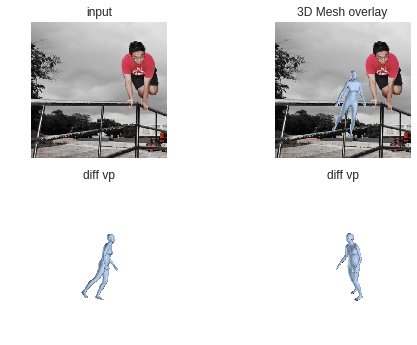

<Figure size 576x396 with 0 Axes>

In [53]:
tf.reset_default_graph()
config = flags.FLAGS
config(["data/im19"])

# Using pre-trained model, change this to use your own.
config.load_path = src.config.PRETRAINED_MODEL

config.batch_size = 1

Gverts = None
renderer = vis_util.SMPLRenderer(face_path=config.smpl_face_path)
config.img_path = "data/s31/01301_image.png"
main(config.img_path, config.json_path)

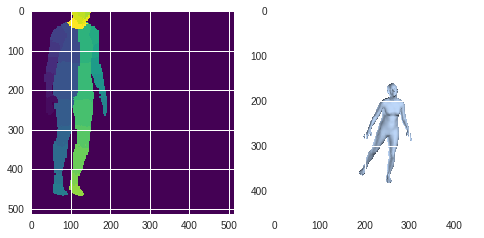

In [0]:
#img1 = plt.imread("data/s31/01410_image.png")
fg = plt.imread("data/s31/02421_ann_vis.png")[:,:,:3]

#plt.imshow(img1);
plt.subplot(121);plt.imshow(fg[:,:,:3]);
plt.subplot(122);plt.imshow(Gverts)

Test on our own example, properly cropped.

Iteration 0
Iteration 1
Reuse is on!
Iteration 2
Reuse is on!
Restoring checkpoint /content/hmr/src/../models/model.ckpt-667589..
INFO:tensorflow:Restoring parameters from /content/hmr/src/../models/model.ckpt-667589


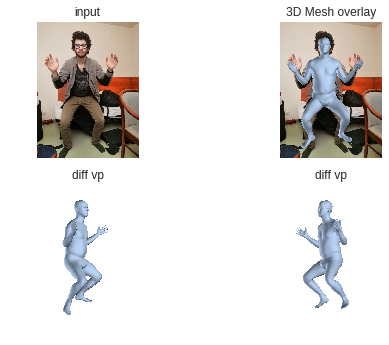

<Figure size 576x396 with 0 Axes>

In [0]:
tf.reset_default_graph()
config = flags.FLAGS
config(["data/im19"])

# Using pre-trained model, change this to use your own.
config.load_path = src.config.PRETRAINED_MODEL

config.batch_size = 1

Gverts = None
renderer = vis_util.SMPLRenderer(face_path=config.smpl_face_path)

config.img_path = "data/custom/001.jpg"
main(config.img_path, config.json_path)

In [0]:
def f1score(Ypred,Ytest):

    tp = np.sum((Ypred == Ytest)[Ypred == False])
    fp = np.sum((Ypred != Ytest)[Ypred == False])
    fn = np.sum((Ypred != Ytest)[Ytest == False])
    p = tp/(tp + fp)
    r = tp/(tp + fn)
    if tp+fp ==0 or tp+fn ==0 or tp == 0: return 0


    return 2* (p*r)/(p+r)

In [0]:
# Indices of used images to evaluate the model by the researcher
lsps = []
for i in range(8515):
  origin = open("data/up-3d/"+ ('0000'+str(i))[-5:]+"_dataset_info.txt")
  source = origin.read()
  if "lsp " in source:
    lsps.append(i)
lsps = np.array(lsps)
    

In [0]:
lsps.shape

(1292,)

In [0]:
"""
up3d joints, same first as this numerotation, useful to compare the output to
the different dataset.

0 right ankle     
1 right knee      
2 right hip       
3 left hip       
4 left knee
5 left ankle
6 right wrist
7 right elbow
8 right shoulder
9 left shoulder
10 left elbow
11 left wrist
12 neck
13 head top
"""

'\nup3d joints, same first as this numerotation\n\n0 right ankle     \n1 right knee      \n2 right hip       \n3 left hip       \n4 left knee\n5 left ankle\n6 right wrist\n7 right elbow\n8 right shoulder\n9 left shoulder\n10 left elbow\n11 left wrist\n12 neck\n13 head top\n'

# Video

Load a dataset for video, not used by the paper.

In [0]:
!mkdir video

In [0]:
%cd data
!wget http://virtualhumans.mpi-inf.mpg.de/3DPW/imageFiles.zip
!unzip imageFiles.zip
!rm imageFiles.zip
%cd ../

In [0]:
%cd data
!wget http://virtualhumans.mpi-inf.mpg.de/3DPW/sequenceFiles.zip
!unzip sequenceFiles.zip
!rm sequenceFiles.zip
%cd ../

In [0]:
"""
SMPL MODEL:
0 : pelvis
1 : left hip               3
2 : right hip              2
3 : spine1
4 : left knee              4
5 : right knee             1
6 : spine2
7 : left ankle             5
8 : right ankle            0
9 : spine3
10 : left foot
11 : right foot
12 : neck                  12
13 : left collar
14 : right collar
15 : head                  13
16 : left shoulder         9
17 : right shoulder        8
18 : left elbow            10
19 : right elbow           7
20 : left wrist            11
21 : right wrist           6
22 : left hand
23 : right hand
"""
joint_rot3d = np.array([8,5,2,1,4,7,21,19,17,16,18,20,12,15])

In [0]:
"""
Predicted -> True
0 -> 14    nose
1 -> 12    neck
2 -> 8     r_shoulder
3 -> 7     r_elbow
4 -> 6    r_wrist
5 -> 9     l_shoulder
6 -> 10     l_elbow
7 -> 11     l_wrist
8 -> 2     r_hip
9 -> 1     r_knee
10 -> 0    r_ankle
11 -> 3    l_hip
12 -> 4    l_knee
13 -> 5    l_ankle
14 -> 16   r_eye
15 -> 15   l_eye
16 -> 18   r_ear
17 -> 17   l_ear

['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 
 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 
 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']
[0:nose,1:neck, 2:rightshoulder, 3:right elbow, 4:right wrist,5:leftshoulder, 6:left elbow,
7:left wrist, 8:right hip,9:right knee, 10:right ankle, 11:left hip, 12:left knee, 13:left ankle, 14:right eye,
15:left eye, 16:right ear, 17:left ear]
"""
rot2d=np.array([14,12,8,7,6,9,10,11,2,1,0,3,1,5,16,15,18,17])

Below, we use the trained model to make predictions (pose, joint angles) on videos. To have a smoother results, we take the mean of the output every 3 images (output[0] = prediction[0], output[1] = 0.5*(output[0] + output[2]), output[2] = prediction[2]).

6 different videos are writtent (take about ~30 min to compute for 1 min of video): input, joint angles 2D projection, 3D Mesh Overlay on images, 3D Mesh, view point 1 and view point 2

In [0]:
def write_video(img, proc_param, joints, verts, cam, boucle=False, write_frame=False, dataset='3dpw'):
    """
    Makes prediction on video frame by frame.
    Renders the result in original image coordinate frame.
    Modifies directly global variables.
    
    @parameter: img (ndarray) : Input image
    @parameter: joints (ndarray) : Predicted joint angles (SMPL model)
    @parameter: verts (ndarray) : Vertices of points (SMPL model)
    @parameter: cam (ndarray) : Camera parameters
    @parameter: boucle : True to take the mean every 3 frames.
    @parameter: write_video : True to write the output as video files
    """
    global joints_up3d
    global joints_diff_fb, joints_diff_md
    global fg_metric, f1, fg
    global rendd
    global frames
    global frame_nb, frame_written

    
    

    
    if not boucle:
      
      cam_for_render, vert_shifted,joints_orig = vis_util.get_original(
            proc_param, verts, cam, joints, img_size=img.shape[:2])
      
      # Predicts
      rend_img = renderer(
      vert_shifted, cam=cam_for_render, img_size=img.shape[:2])
      Gverts= rend_img
      
      # Compute metrics (accuracy and f1 score)
      fg_metric[frame_nb]=((Gverts == Gverts[0,0]) == (fg == fg[0,0])).prod(2).sum()/(Gverts.shape[0]*Gverts.shape[1])
      f1[frame_nb] = f1score(Gverts == Gverts[0,0],fg == fg[0,0])
      frame_nb += 1
      
      
      
    
    else:
      global cam_for_renders, vert_shifteds, joints_origs, imgs
      global divider
      
      cam_for_renders[divider], vert_shifteds[divider], joints_origs[divider] = vis_util.get_original(
          proc_param, verts, cam, joints, img_size=img.shape[:2])

      imgs[divider] = img
      
      if divider == 0:  
        for ar in [cam_for_renders,vert_shifteds,joints_origs]:
          ar[2] = 1/2 * (ar[1] + ar[0])

        for i in [1,2,0]: 
          # Evaluation
          cam_for_render = cam_for_renders[i]
          vert_shifted = vert_shifteds[i]
          joints_orig = joints_origs[i]
          img = imgs[i]
          
          
          if dataset == '3dpw':
            # Evaluation on the joints, pixel wise
            rot2d=np.array([14,12,8,7,6,9,10,11,2,1,0,3,1,5,16,15,18,17])
            totake1 = np.equal(trueJoints[frame_nb][:2].T,np.zeros(2)).sum(1).astype(bool)
            joints_orig[rot2d][totake1]=np.zeros((totake1.sum(),2))
            
            joints_diff_md[frame_nb] = np.sqrt((((joints_orig[rot2d] - trueJoints[frame_nb][:2,:].T)**2).sum(1))).mean()
            totake2 = np.not_equal(trueJoints[frame_nb][:2].T,np.zeros(2)).sum(1).astype(bool)
            joints_diff_fb[frame_nb] = np.linalg.norm((joints_orig[rot2d] - trueJoints[frame_nb][:2].T))

          frame_nb += 1
          if frame_nb in [0,1,2]:
            break
          
          # Predicts
          rend_img = renderer(
              vert_shifted, cam=cam_for_render, img_size=img.shape[:2])
          Gverts= rend_img
          
          
          # Output video
          if write_frame:
            # Render results
            skel_img = vis_util.draw_skeleton(img, joints_orig)
            rendd = renderer(
             vert_shifted, cam=cam_for_render, img=img, do_alpha=True)
            
            rend_img_vp1 = renderer.rotated(
               vert_shifted, 60, cam=cam_for_render, img_size=img.shape[:2])
            rend_img_vp2 = renderer.rotated(
               vert_shifted, -60, cam=cam_for_render, img_size=img.shape[:2])
          
            rotation = np.array([2,1,0])
            writers[0].write(img[:,:,rotation])   #input
            writers[1].write(skel_img[:,:,rotation])  #joint projection
            writers[2].write(rendd[:,:,:3][:,:,rotation]) #3D Mesh Overlay
            writers[3].write(rend_img[:,:,rotation])   #3D Mesh
            writers[4].write(rend_img_vp1[:,:,rotation])  #view point 1
            writers[5].write(rend_img_vp2[:,:,rotation])  #view point 2
            frame_written += 1

      divider = (divider+ 1) %3

def main2(img_path, writers, json_path=None, boucle=False, write_frame=False, dataset='3dpw'):

    global joints300
    
    input_img, proc_param, img = preprocess_image(img_path, json_path)
    # Add batch dimension: 1 x D x D x 3
    input_img = np.expand_dims(input_img, 0)

    # Theta is the 85D vector holding [camera, pose, shape]
    # where camera is 3D [s, tx, ty]
    # pose is 72D vector holding the rotation of 24 joints of SMPL in axis angle format
    # shape is 10D shape coefficients of SMPL
    joints, verts, cams, joints3d, theta = model.predict(
        input_img, get_theta=True)
    
    write_video(img, proc_param, joints[0], verts[0], cams[0], boucle=boucle, 
                write_frame = write_frame, dataset=dataset)

Below code to predict (and write as a video file if necessary) frame by frame from a video. Images should be already split and in a common folder.

In [67]:
import pickle
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm


path = "data/imageFiles/outdoors_parcours_00/"
with open('data/sequenceFiles/validation/outdoors_parcours_00.pkl', 'r') as f:
   trueDat = pickle.load(f)
    
trueJoints = trueDat["poses2d"][0]

writers = []
fourcc = cv2.VideoWriter_fourcc(*'XVID')
for title in ["input.avi","joint.avi","3d_overlay.avi","3d_mesh.avi","diff_vp_1.avi","diff_vp_2.avi"]:
  writers.append(cv2.VideoWriter("video/"+title,fourcc,20.0,(1080,1920),isColor = True))

tf.reset_default_graph()

config = flags.FLAGS
# Using pre-trained model, change this to use your own.
config.load_path = src.config.PRETRAINED_MODEL

config.batch_size = 1

sess = tf.Session()
model = RunModel(config, sess=sess)

debut =0
nb_totframes = 1661  #total frames for outdoors_parcours_00 = 1661
#frames = np.zeros((nb_totframes,1920,1080,3))
frame_nb = 0
divider = 0
rendd = None
#joints300 = None

# Create empty arrays for video
joints_diff_fb = np.zeros((nb_totframes-debut))
joints_diff_md = np.zeros(nb_totframes-debut)
fg_metric = np.zeros(nb_totframes-debut)
f1 = np.zeros(nb_totframes-debut)

# 3 of depth to keep 3 frames in memory for mean smoothing
imgs = np.zeros((3,1920,1080,3))
cam_for_renders = np.zeros((3,3))
vert_shifteds = np.zeros((3,6890,3))
joints_origs = np.zeros((3,19,2))


frame_written = 0
for i in tqdm(range(debut,nb_totframes)):
  #joints_up3d = np.load(path +  ('0000'+str(i))[-5:] + "_joints.npy")
  renderer = vis_util.SMPLRenderer(face_path=config.smpl_face_path)
  try: config.img_path = (path + 'image_' + ('0000'+str(i))[-5:] + '.jpg')
  except: print("Could not read:",(path + 'image_' + ('0000'+str(i))[-5:] + 'jpg'));break
  main2(config.img_path, config.json_path, boucle=True, write_frame=False, dataset='3dpw')
  

for writer in writers:
  writer.release()

Iteration 0
Iteration 1
Reuse is on!
Iteration 2
Reuse is on!
Restoring checkpoint /content/hmr/src/../models/model.ckpt-667589..
INFO:tensorflow:Restoring parameters from /content/hmr/src/../models/model.ckpt-667589


100%|██████████| 1661/1661 [19:15<00:00,  1.55it/s]


Save our metrics matrices (long to compute).

Text(0.5,1,'Mean distance between joints')

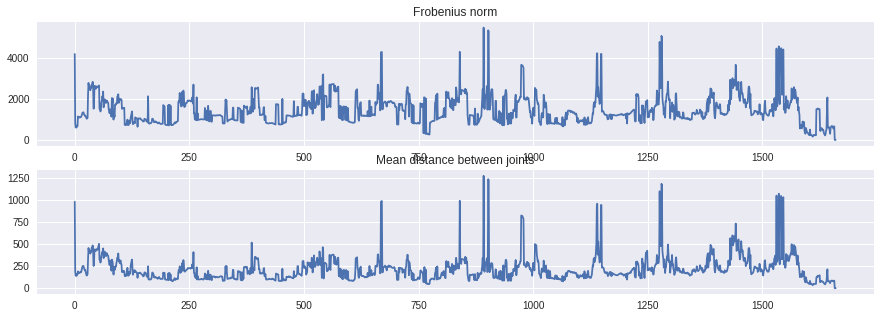

In [68]:
plt.figure(figsize = (15,5))
plt.subplot(211);plt.plot(joints_diff_fb); plt.title("Frobenius norm")
plt.subplot(212);plt.plot(joints_diff_md); plt.title("Mean distance between joints")

# Evaluation on the up-3D dataset

In [69]:
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
path = "data/s31/"

tf.reset_default_graph()

config = flags.FLAGS
# Using pre-trained model, change this to use your own.
config.load_path = src.config.PRETRAINED_MODEL

config.batch_size = 1

sess = tf.Session()
model = RunModel(config, sess=sess)

debut =0
nb_totframes = 8515
#frames = np.zeros((nb_totframes,1920,1080,3))
frame_nb = 0
divider = 0
rendd = None
#joints300 = None

# Create empty arrays
fg_metric = np.zeros(nb_totframes-debut)
f1 = np.zeros(nb_totframes-debut)


frame_written = 0
for i in tqdm(range(debut,nb_totframes)):
  #joints_up3d = np.load(path +  ('0000'+str(i))[-5:] + "_joints.npy")
  renderer = vis_util.SMPLRenderer(face_path=config.smpl_face_path)
  try: config.img_path = (path + ('0000'+str(i))[-5:] + "_image.png")
  except: print("Could not read:",(path + ('0000'+str(i))[-5:] + "_image.png"));break
  fg=plt.imread(path +  ("0000"+str(i))[-5:] + "_ann_vis.png")[:,:,:3]
  main2(config.img_path, config.json_path, dataset='up3d')

Iteration 0
Iteration 1
Reuse is on!
Iteration 2
Reuse is on!
Restoring checkpoint /content/hmr/src/../models/model.ckpt-667589..
INFO:tensorflow:Restoring parameters from /content/hmr/src/../models/model.ckpt-667589


100%|██████████| 8515/8515 [1:04:37<00:00,  2.15it/s]


In [0]:
np.save('fg_vs_bg_acc',fg_metric)
np.save('fg_vs_bg_f1',f1)

Plot f1 score for each image.

0.9344505215299941
0.800618106187283


Text(0.5,1,'Evaluation on the whole up-3d dataset')

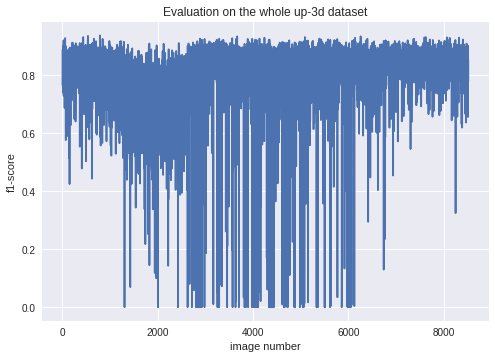

In [70]:
print(fg_metric.mean())
print(f1.mean())
plt.plot(f1);
plt.ylabel("f1-score"); plt.xlabel("image number")
plt.title("Evaluation on the whole up-3d dataset")

Here we plot f1 score for each frame of the "lsps" sub-dataset, used by the researcher.

0.9146868408647617
0.817090832269468


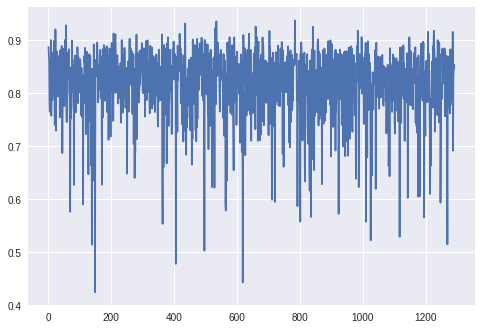

In [0]:
print(fg_metric[lsps].mean())
print(f1[lsps].mean())
plt.plot(f1[lsps])

In [73]:
print("number of images with F1 score:")
print("<0.2: ", np.sum(f1<0.2))
print("<0.4: ", np.sum(f1<0.4))
print("<0.6: ", np.sum(f1<0.6))
print("<0.8: ", np.sum(f1<0.8))
print(">0.8: ", np.sum(f1>0.8))

number of images with F1 score:
<0.2:  118
<0.4:  151
<0.6:  411
<0.8:  2759
>0.8:  5756
